<a href="https://colab.research.google.com/github/lucasgoes21/Machine-Learning-Final-Project/blob/main/ProjetoFinalAprendMaquina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **O uso de aprendizado de máquina para detecção de spam em emails**

Grupo 09: Amanda Vieira Reis e Lucas Mateus Gonçalves de Góes

# Importação das bibliotecas

In [ ]:
# Data Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PLN

import spacy
try:
  nlp = spacy.load("en_core_web_sm")
except:
  !python -m spacy download en_core_web_sm
  nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import stopwords

# Avaliação

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Tokenização

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Modelagem

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

# Carregando o Dataset

In [ ]:
data = pd.read_csv('/content/Data_set/messages.csv')

data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [ ]:
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [ ]:
data['label'].value_counts()

label
0    2412
1     481
Name: count, dtype: int64

<ipython-input-109-1cac5b267cf8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette=['#00004D',"#008631"])


<Axes: xlabel='label', ylabel='count'>

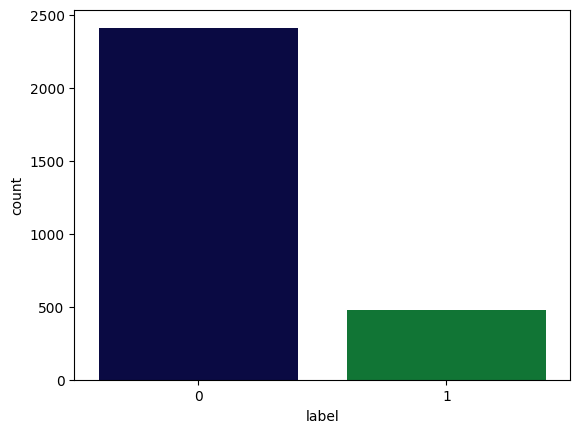

In [ ]:
sns.countplot(x='label', data=data, palette=['#00004D',"#008631"])

# **Pré-processamento**

Em muitos casos, os algoritmos de aprendizado de máquina ainda não estão devidamente aptos para receber qualquer tipo de dado. No caso deste projeto, será necessário realizar alguns passos de pré-processamento nos textos das colunas.

No Processamento de Linguagem Natural (PLN), os textos não seguem sempre a mesma estrutura. Portanto, é necessário padronizá-los ou, ao menos, aproximá-los. Assim, torna-se possível aos algoritmos manipulá-los.

No pré-processamento iremos utilizar técnicas de: remoção de valores nulos, remoção de caracteres especiais, remoção de *stop words*, lematização, etc

A priori, deve-se remover os valores nulos. Para isso, substituiremos os valores nulos pela moda.

In [ ]:
data.fillna(data['subject'].mode().values[0],inplace=True)

Aqui será utilizada uma estratégia de truncamento do assunto do email com a mensagem. Sendo ambas as características textos, tal estratégia poderá reduzir o trabalho de padronização.

In [ ]:
data['email'] = data['subject'] + ' ' + data['message']

data['email'][1]

'sociolinguistics lang classification grimes , joseph e . and barbara f . grimes ; ethnologue language family index ; pb . isbn : 0-88312 - 708 - 3 ; vi , 116 pp . ; $ 14 . 00 . summer institute of linguistics . this companion volume to ethnologue : languages of the world , twelfth edition lists language families of the world with sub-groups shown in a tree arrangement under the broadest classification of language family . the language family index facilitates locating language names in the ethnologue , making the data there more accessible . internet : academic . books @ sil . org languages , reference lang & culture gregerson , marilyn ; ritual , belief , and kinship in sulawesi ; pb . : isbn : 0-88312 - 621 - 4 ; ix , 194 pp . ; $ 25 . 00 . summer institute of linguistics . seven articles discuss five language groups in sulawesi , indonesia ; the primary focus is on cultural matters , with some linguistic content . topics include traditional religion and beliefs , certain ceremonies

In [ ]:
# Remoção das quebras de linhas
data['email']=data['email'].str.replace(r'\n',"")

data['email'][1]

'sociolinguistics lang classification grimes , joseph e . and barbara f . grimes ; ethnologue language family index ; pb . isbn : 0-88312 - 708 - 3 ; vi , 116 pp . ; $ 14 . 00 . summer institute of linguistics . this companion volume to ethnologue : languages of the world , twelfth edition lists language families of the world with sub-groups shown in a tree arrangement under the broadest classification of language family . the language family index facilitates locating language names in the ethnologue , making the data there more accessible . internet : academic . books @ sil . org languages , reference lang & culture gregerson , marilyn ; ritual , belief , and kinship in sulawesi ; pb . : isbn : 0-88312 - 621 - 4 ; ix , 194 pp . ; $ 25 . 00 . summer institute of linguistics . seven articles discuss five language groups in sulawesi , indonesia ; the primary focus is on cultural matters , with some linguistic content . topics include traditional religion and beliefs , certain ceremonies

In [ ]:
# Substituição do símbolo '$'

data['email']=data['email'].str.replace(r'$', 'money')

data['email'][2887]

"win money 300usd and a cruise ! raquel 's casino , inc . is awarding a cruise + money 300 to a lucky member . no purchase necessary to play ! join before month end to participate . ( you will automatically be enteredinto the next drawing . ) you can join at http : / / www . raquelscasino . com ( casino ) http : / / www . tobet . com ( sportsbook ) raquel 's online casino provides guests with a state-of - the-art gaming experience : - a chance to win a cruise and money 300 ! - 10 % sign-up bonus ! - free casino software ! - 25 casino games ! - international sportsbook ! - horse racing ! - play for fun , or for real ! our casino is secure , audited , private , and insured . thank you for your time and consideration . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *\n"

In [ ]:
#Substituição dos numeros de telefone
#Vale a observação que nem todos os números de telefone foram substituidos corretamente, porém, a maioria segue os passos do codigo

data['email']=data['email'].str.replace("(.?){0,2}\d?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4})", "phonenumber")
data['email']=data['email'].str.replace(r'\+?\d{1,4}[-.\s]*\(?\d{1,3}\)?[-.\s]*\d{1,4}[-.\s]*\d{1,4}[-.\s]*\d{1,9}', 'phonenumber', regex=True)

data['email'][302]


'changes in the journal language the editorial staff and offices of the journal language have been changed as of this month . articles for submission and general correspondence should be sent to the following address : mark aronoff , editor language department of linguistics suny stony brook stony brook , ny phonenumber , usa book reviews and all correspondence concerning reviews should be sent to the following address : edwin battistella , review editor language division of humanities wayne state college wayne , ne phonenumber , usa both offices may be reached by email : main office : language . eds @ sunysb . edu review office : langrev @ wscgate . wsc . edu the main office may be reached by telephone : phone : phonenumber fax : phonenumber\n'

In [ ]:
#Substituição dos numeros por 'number'

data['email']=data['email'].str.replace(r'\d+(\.\d+)?', 'number ', regex=True)
data['email'][2887]

"win money number usd and a cruise ! raquel 's casino , inc . is awarding a cruise + money number  to a lucky member . no purchase necessary to play ! join before month end to participate . ( you will automatically be enteredinto the next drawing . ) you can join at http : / / www . raquelscasino . com ( casino ) http : / / www . tobet . com ( sportsbook ) raquel 's online casino provides guests with a state-of - the-art gaming experience : - a chance to win a cruise and money number  ! - number  % sign-up bonus ! - free casino software ! - number  casino games ! - international sportsbook ! - horse racing ! - play for fun , or for real ! our casino is secure , audited , private , and insured . thank you for your time and consideration . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *\n"

In [ ]:
data['email'][2887]

"win money number usd and a cruise ! raquel 's casino , inc . is awarding a cruise + money number  to a lucky member . no purchase necessary to play ! join before month end to participate . ( you will automatically be enteredinto the next drawing . ) you can join at http : / / www . raquelscasino . com ( casino ) http : / / www . tobet . com ( sportsbook ) raquel 's online casino provides guests with a state-of - the-art gaming experience : - a chance to win a cruise and money number  ! - number  % sign-up bonus ! - free casino software ! - number  casino games ! - international sportsbook ! - horse racing ! - play for fun , or for real ! our casino is secure , audited , private , and insured . thank you for your time and consideration . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *\n"

In [ ]:
# Remoção dos caracteres especiais
data['email']=data['email'].str.replace(r"[^a-zA-Z0-9@]+", " ", regex=True)

data['email'][1]

'sociolinguistics lang classification grimes joseph e and barbara f grimes ethnologue language family index pb isbn phonenumber vi number pp money number number summer institute of linguistics this companion volume to ethnologue languages of the world twelfth edition lists language families of the world with sub groups shown in a tree arrangement under the broadest classification of language family the language family index facilitates locating language names in the ethnologue making the data there more accessible internet academic books @ sil org languages reference lang culture gregerson marilyn ritual belief and kinship in sulawesi pb isbn phonenumber ix number pp money number number summer institute of linguistics seven articles discuss five language groups in sulawesi indonesia the primary focus is on cultural matters with some linguistic content topics include traditional religion and beliefs certain ceremonies and kinship internet academic books @ sil org language and society in

In [ ]:
# Remoção de stop words
nltk.download('stopwords')
swords = nlp.Defaults.stop_words

sw = list(set(stopwords.words('english') + list(swords)))

data['email'] = data['email'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

data['email'][1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'sociolinguistics lang classification grimes joseph e barbara f grimes ethnologue language family index pb isbn phonenumber vi number pp money number number summer institute linguistics companion volume ethnologue languages world twelfth edition lists language families world sub groups shown tree arrangement broadest classification language family language family index facilitates locating language names ethnologue making data accessible internet academic books @ sil org languages reference lang culture gregerson marilyn ritual belief kinship sulawesi pb isbn phonenumber ix number pp money number number summer institute linguistics seven articles discuss language groups sulawesi indonesia primary focus cultural matters linguistic content topics include traditional religion beliefs certain ceremonies kinship internet academic books @ sil org language society indonesia computers ling weber david j stephen r mcconnel diana weber beth j bryson primer tool developing early reading materials

In [ ]:
#Lematização
# Para que a lematização ficasse menos demorada e mais precisa utilizamos o código
# disponível no seguinte link: https://stackoverflow.com/questions/75214153/lemmatization-taking-forever-with-spacy
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in nlp.pipe(data["email"]):
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
data["email"] = lemma_text_list

data['email'][1]


'sociolinguistic lang classification grime joseph e barbara f grime ethnologue language family index pb isbn phonenumber vi number pp money number number summer institute linguistics companion volume ethnologue language world twelfth edition list language family world sub group show tree arrangement broad classification language family language family index facilitate locate language name ethnologue make datum accessible internet academic book @ sil org language reference lang culture gregerson marilyn ritual belief kinship sulawesi pb isbn phonenumber ix number pp money number number summer institute linguistic seven article discuss language group sulawesi indonesia primary focus cultural matter linguistic content topic include traditional religion belief certain ceremony kinship internet academic book @ sil org language society indonesia computer le weber david j stephen r mcconnel diana weber beth j bryson primer tool develop early reading material pb isbn phonenumber xvi number pp 

In [ ]:
data['email'][5]

'abstract optimality syntactic theory content length number paper good good workshop optimality syntactic theory hold massachusetts institute technology cambridge phonenumber syntactic research variety framework assign grow role notion comparison work forefront current research include theory involve principle economy optimality work unpublished formative stage legendre raymond smolensky number grimshaw number pesetsky number chomsky number number number relevant datum vary account empirical comparison proposal undertake number number number mit host workshop explore clarify particular issue syntactic theory comparison play significant role workshop consist invite talk talk select anonymously submit abstract abstract invite address follow question nature candidate reference set comparison linguistic object compete good choice criterion determine optimal output set candidate grammar compare derivation economy principle chomsky number number representation optimality theoretic analysis d

In [ ]:
data['email'][0]

'job post apple iss research center content length number apple iss research center money number million joint venture apple computer inc institute systems science national university singapore locate singapore look senior speech scientist successful candidate research expertise computational linguistic include natural language process english chinese statistical language model knowledge state art corpus base n gram language model cache language model speech language model require text speech project leader successful candidate research expertise expertise follow area computational linguistic include natural language parse lexical database design statistical language model text tokenization normalization prosodic analysis substantial knowledge phonology syntax semantics chinese require knowledge acoustic phonetics speech signal processing desirable candidate phd number number year relevant work experience technical msc degree number number year experienc e strong software engineering s

In [ ]:
data = data.drop(['message', 'subject'], axis=1)

In [ ]:
data

,label,email
0,0,job post apple iss research center content len...
1,0,sociolinguistic lang classification grime jose...
2,0,query letter frequency text identification pos...
3,0,risk colleague research differ degree risk per...
4,0,request book information early morning phone f...
...,...,...
2888,1,love profile ysuolvpv hello thank stop take ne...
2889,1,ask join kiddin list owner kiddin invite join ...
2890,0,anglicization composer name judge return post ...
2891,0,number number comparative method n ary compari...


In [ ]:
#Aqui há uma tentativa de relacionar a label com o tamanho da mensagem, a qual não foi
#bem sucedida.

data['length'] = data.email.apply(len) #representa o comprimento do tamanho da mensagem
data.head()

,label,email,length
0,0,job post apple iss research center content len...,1983
1,0,sociolinguistic lang classification grime jose...,1389
2,0,query letter frequency text identification pos...,923
3,0,risk colleague research differ degree risk per...,180
4,0,request book information early morning phone f...,557


# Tokenização

In [ ]:
#Divisão dos dados em conjuntos de treinamento e teste (30% dos dados devem ser reservados para o conjunto de teste)
X_train, X_test, y_train, y_test = train_test_split(data.email, data.label, test_size = 0.3, stratify=data.label)

print(X_train)

725     perceive perform gender perceive perform gende...
43      recommendation le font set mac look recommenda...
2683    net survey win free trip phonenumber net surve...
192     lowland l discussion list year discussion list...
291     release agfl home page message announce releas...
                              ...                        
2672    teach material statistical cl content length n...
721     hpsgnumber program international conference he...
785     adult ad viva la revolution viva la revolution...
258     sociolinguistic phonology phonetic leiden hil ...
1181    understand pragmatic update understanding prag...
Name: email, Length: 2025, dtype: object


In [ ]:
vectorizer = TfidfVectorizer(min_df=3) #os termos (palavras) que aparecem em menos de 3 documentos serão ignorados.

X = vectorizer.fit_transform(X_train)

vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaai', ..., 'zwicky', 'zwischen', 'zygmunt'],
      dtype=object)

In [ ]:
print(vectorizer.get_stop_words())

None


In [ ]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,aa,aaa,aaai,aachen,aalborg,aamt,aan,aarhus,aaron,aart,...,zubizarreta,zum,zur,zurich,zwart,zwei,zweigenbaum,zwicky,zwischen,zygmunt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVM

In [ ]:
svm=SVC()

In [ ]:
pipe = Pipeline(steps=[("vectorizer", vectorizer), ("classifier", svm)])

param_grid = {"classifier__kernel":['linear', 'poly', 'rbf', 'sigmoid'], "classifier__C":[1, 3, 7]}

best_svm = GridSearchCV(pipe, param_grid, scoring=('f1_weighted'), cv=3)

model_svm = best_svm.fit(X_train, y_train)

df = pd.DataFrame(best_svm.cv_results_)

df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.621142,0.569378,0.870476,0.278953,1,linear,"{'classifier__C': 1, 'classifier__kernel': 'li...",0.992552,0.986440,0.986495,0.988496,0.002868,5
1,2.650064,0.190057,1.160335,0.014873,1,poly,"{'classifier__C': 1, 'classifier__kernel': 'po...",0.901168,0.877976,0.864770,0.881305,0.015044,12
2,2.313815,0.263151,0.890379,0.178917,1,rbf,"{'classifier__C': 1, 'classifier__kernel': 'rbf'}",0.978782,0.980257,0.969322,0.976120,0.004845,9
3,0.808063,0.014007,0.373063,0.012808,1,sigmoid,"{'classifier__C': 1, 'classifier__kernel': 'si...",0.989534,0.986440,0.988018,0.987998,0.001263,6
4,1.042371,0.154074,0.534214,0.075301,3,linear,"{'classifier__C': 3, 'classifier__kernel': 'li...",0.994053,0.986440,0.991047,0.990513,0.003130,2
5,2.781100,0.318163,1.150712,0.010190,3,poly,"{'classifier__C': 3, 'classifier__kernel': 'po...",0.905175,0.907157,0.869350,0.893894,0.017374,10
6,2.288421,0.296396,0.943286,0.153912,3,rbf,"{'classifier__C': 3, 'classifier__kernel': 'rbf'}",0.983427,0.983362,0.978787,0.981859,0.002172,7
7,0.780881,0.026946,0.360493,0.008559,3,sigmoid,"{'classifier__C': 3, 'classifier__kernel': 'si...",0.991046,0.987970,0.992553,0.990523,0.001907,1
8,0.898865,0.006998,0.480463,0.077643,7,linear,"{'classifier__C': 7, 'classifier__kernel': 'li...",0.994053,0.986440,0.989535,0.990009,0.003126,3
9,2.798017,0.340437,1.255808,0.142635,7,poly,"{'classifier__C': 7, 'classifier__kernel': 'po...",0.905175,0.907157,0.869350,0.893894,0.017374,10


In [ ]:
best_svm.best_params_

{'classifier__C': 3, 'classifier__kernel': 'sigmoid'}

In [ ]:
y_pred = model_svm.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

matrix

array([[724,   0],
       [  1, 143]])

Text(50.722222222222214, 0.5, 'Truth')

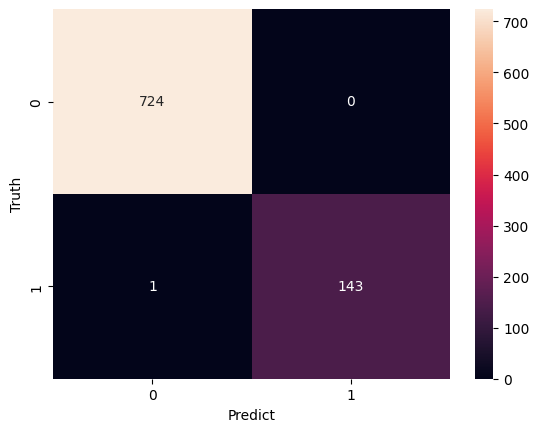

In [ ]:
# Criando um heatmap para melhor visualização

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Predict")
plt.ylabel("Truth")

In [ ]:
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("Precision: ", precision_score(y_pred,y_test, average = 'weighted'))
print("Recall: ", recall_score(y_pred,y_test, average = 'weighted'))
print("F1 Score: ", f1_score(y_pred,y_test, average = 'weighted'))

Accuracy:  0.9988479262672811
Precision:  0.9988559267793139
Recall:  0.9988479262672811
F1 Score:  0.998849535823406


# Naive Bayes

In [ ]:
nb = MultinomialNB()

In [ ]:
pipe = Pipeline([('vectorizer',vectorizer),('classifier',nb)])
model_nb = pipe.fit(X_train,y_train)

In [ ]:
y_pred = model_nb.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

matrix

array([[724,   0],
       [ 26, 118]])

Text(50.722222222222214, 0.5, 'Truth')

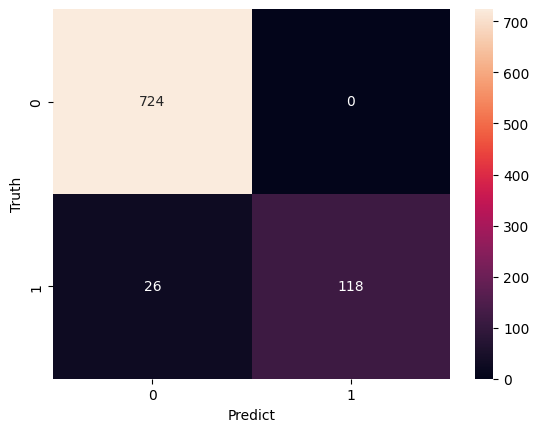

In [ ]:
# Criando um heatmap para melhor visualização

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Predict")
plt.ylabel("Truth")

In [ ]:
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("Precision: ", precision_score(y_pred,y_test, average = 'weighted'))
print("Recall: ", recall_score(y_pred,y_test, average = 'weighted'))
print("F1 Score: ", f1_score(y_pred,y_test, average = 'weighted'))

Accuracy:  0.9700460829493087
Precision:  0.9754544290834614
Recall:  0.9700460829493087
F1 Score:  0.9712681662793208


# KNN

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
pipe = Pipeline(steps=[("vectorizer", vectorizer), ("classifier", KNeighborsClassifier())])

param_grid = {'classifier__n_neighbors':[1, 3, 5, 7], 'classifier__p':[1, 2]}

best_knn = GridSearchCV(pipe, param_grid, scoring=('f1_weighted'), cv=3)

model_knn = best_knn.fit(X_train, y_train)

df = pd.DataFrame(best_knn.cv_results_)

df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_classifier__p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.336381,0.002197,0.609666,0.002004,1,1,"{'classifier__n_neighbors': 1, 'classifier__p'...",0.758617,0.760644,0.756535,0.758599,0.001677,5
1,0.439652,0.126834,17.990383,0.623985,1,2,"{'classifier__n_neighbors': 1, 'classifier__p'...",0.943277,0.927552,0.945168,0.938666,0.007896,2
2,0.337249,0.002468,0.613754,0.002274,3,1,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.758617,0.070270,0.756535,0.528474,0.324000,6
3,0.338660,0.004073,17.370510,0.246078,3,2,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.958348,0.901406,0.911341,0.923698,0.024834,4
4,0.625316,0.004625,0.882390,0.099713,5,1,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.758617,0.047227,0.756535,0.520793,0.334863,8
5,0.351616,0.014677,17.268707,0.130214,5,2,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.966447,0.885185,0.934699,0.928777,0.033438,3
6,0.340314,0.000948,0.639630,0.048020,7,1,"{'classifier__n_neighbors': 7, 'classifier__p'...",0.758617,0.050244,0.756535,0.521799,0.333440,7
7,0.438432,0.113249,18.741797,2.028463,7,2,"{'classifier__n_neighbors': 7, 'classifier__p'...",0.964693,0.957831,0.972537,0.965020,0.006009,1


In [ ]:
best_knn.best_params_

{'classifier__n_neighbors': 7, 'classifier__p': 2}

In [ ]:
y_pred = model_knn.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

matrix

array([[673,  51],
       [  2, 142]])

Text(50.722222222222214, 0.5, 'Truth')

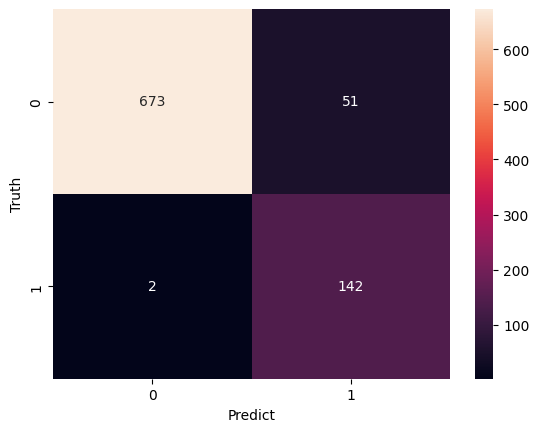

In [ ]:
# Criando um heatmap para melhor visualização

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Predict")
plt.ylabel("Truth")

In [ ]:
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("Precision: ", precision_score(y_pred,y_test, average = 'weighted'))
print("Recall: ", recall_score(y_pred,y_test, average = 'weighted'))
print("F1 Score: ", f1_score(y_pred,y_test, average = 'weighted'))

Accuracy:  0.9389400921658986
Precision:  0.9421326058790415
Recall:  0.9389400921658986
F1 Score:  0.9355703309292046
